# Проект: классификация

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [19]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [20]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [21]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [22]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [23]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace('$', '', regex=False).str.replace(',', '.').str.replace(' ', '').astype(float)

In [24]:
round(df['balance'].mean(), 3)

np.float64(1529.129)

### Задание 4

In [25]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'].fillna(df['balance'].median(), inplace=True)

In [26]:
round(df['balance'].mean(), 3)

np.float64(1526.936)

### Задание 5

In [27]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df['job'] = df['job'].replace('unknown', df['job'].mode()[0])
df['education'] = df['education'].replace('unknown', df['education'].mode()[0])

In [28]:
# Находим самую популярную работу и самое популярное образование
most_common_job = df['job'].mode()[0]
most_common_education = df['education'].mode()[0]

# Фильтруем клиентов с самой популярной работой и образованием
filtered_df = df[(df['job'] == most_common_job) & 
                 (df['education'] == most_common_education)]

# Рассчитываем средний баланс
average_balance = round(filtered_df['balance'].mean(), 3)

print(f"Средний баланс для клиентов с job='{most_common_job}' и education='{most_common_education}': {average_balance}")

Средний баланс для клиентов с job='management' и education='secondary': 1598.883


### Задание 6

In [29]:
# удалите все выбросы для признака balance
# ваш код
balance_data = df['balance']

# Вычисляем квартили и IQR
Q1 = balance_data.quantile(0.25)
Q3 = balance_data.quantile(0.75)
IQR = Q3 - Q1

# Определяем границы выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем данные, оставляя только значения внутри границ
filtered_data = balance_data[(balance_data >= lower_bound) & (balance_data <= upper_bound)]

# Если нужно удалить выбросы из исходного DataFrame:
df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

print(f"Q1 (25-й процентиль): {Q1}")
print(f"Q3 (75-й процентиль): {Q3}")
print(f"IQR: {IQR}")
print(f"Нижняя граница выбросов: {lower_bound}")
print(f"Верхняя граница выбросов: {upper_bound}")
print(f"Количество выбросов: {len(balance_data) - len(filtered_data)}")

Q1 (25-й процентиль): 123.0
Q3 (75-й процентиль): 1699.0
IQR: 1576.0
Нижняя граница выбросов: -2241.0
Верхняя граница выбросов: 4063.0
Количество выбросов: 1057


In [30]:
df['balance'].value_counts().sum()

np.int64(10105)

## Часть 2:  Разведывательный анализ

### Задание 1

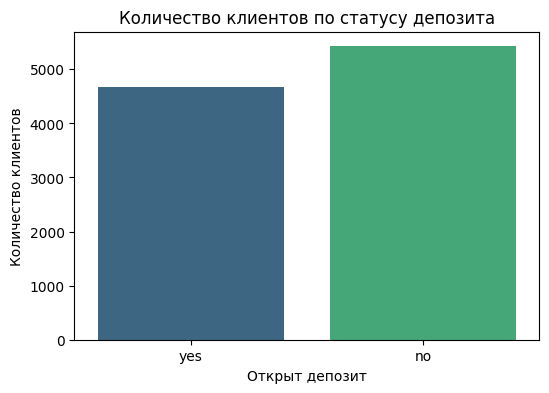

'Открыли депозит: 4681'

In [31]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
deposit_yes_count = df[df['deposit'] == 'yes'].shape[0]

# Строим countplot для столбца 'deposit'
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='deposit', palette='viridis')

plt.title("Количество клиентов по статусу депозита")
plt.xlabel("Открыт депозит")
plt.ylabel("Количество клиентов")
plt.show()
display(f'Открыли депозит: {deposit_yes_count}')

### Задания 2 и 3

,count,mean,std,min,25%,50%,75%,max,IQR
age,10105.0,40.895497,11.734931,18.0,32.0,38.0,48.0,95.0,16.0
duration,10105.0,368.742603,346.651524,2.0,137.0,252.0,490.0,3881.0,353.0


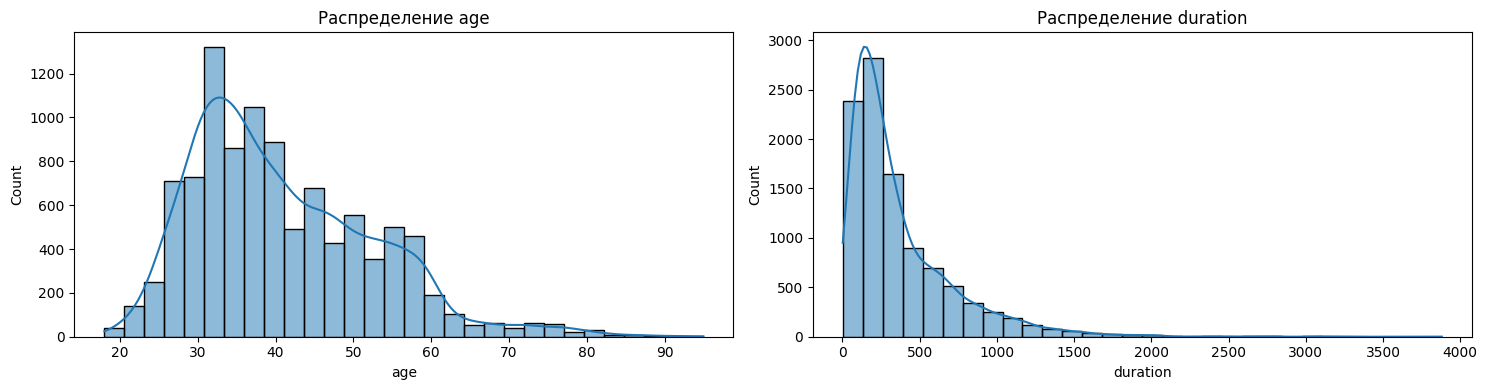

'Максимальный возраст клиента: 95'

'Минимальная продолжительность разговора в секундах клиента: 2'

In [32]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

max_age = df['age'].max()
min_duration = df['duration'].min()

numeric_cols = ['age', 'duration']
desc_stats = df[numeric_cols].describe().T
desc_stats['IQR'] = desc_stats['75%'] - desc_stats['25%']  # Межквартильный размах
display(desc_stats)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], ax=axes[i], kde=True, bins=30)
    axes[i].set_title(f'Распределение {col}')
plt.tight_layout()
plt.show()

display(f'Максимальный возраст клиента: {max_age}')
display(f'Минимальная продолжительность разговора в секундах клиента: {min_duration}')

### Задания 4 и 5

Уникальные категории job: 11
job
management       0.23
blue-collar      0.18
technician       0.16
admin.           0.12
services         0.09
retired          0.07
self-employed    0.04
unemployed       0.03
student          0.03
entrepreneur     0.03
housemaid        0.02
Name: proportion, dtype: float64


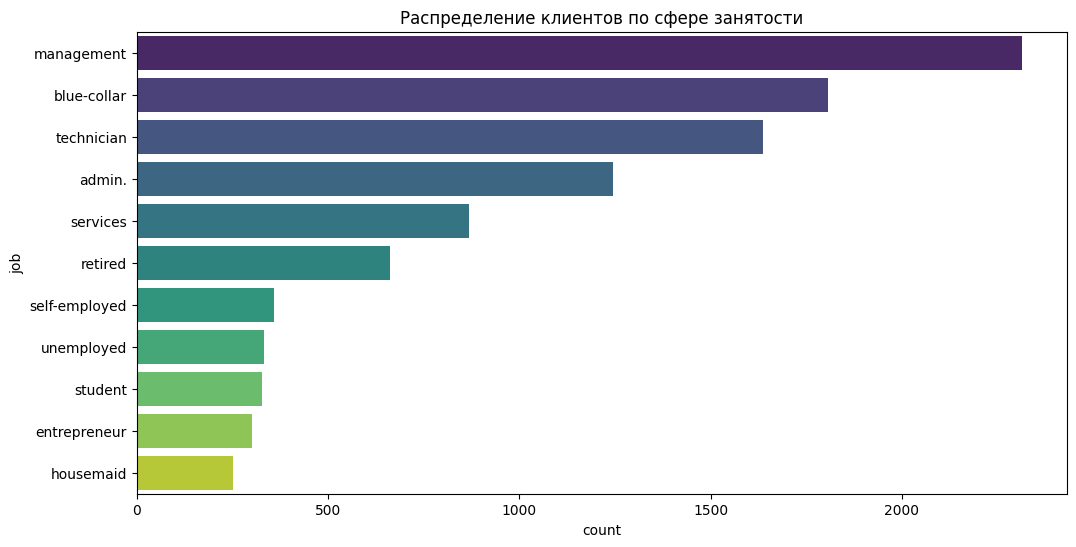

Распределение marital:
 marital
married     0.565562
single      0.317961
divorced    0.116477
Name: proportion, dtype: float64


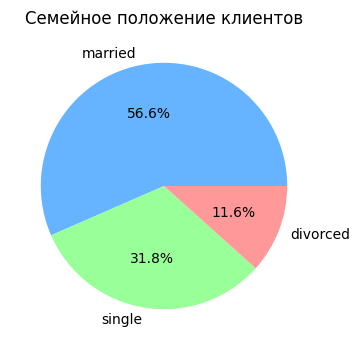

Уровни образования:
 education
secondary    0.55
tertiary     0.32
primary      0.13
Name: proportion, dtype: float64


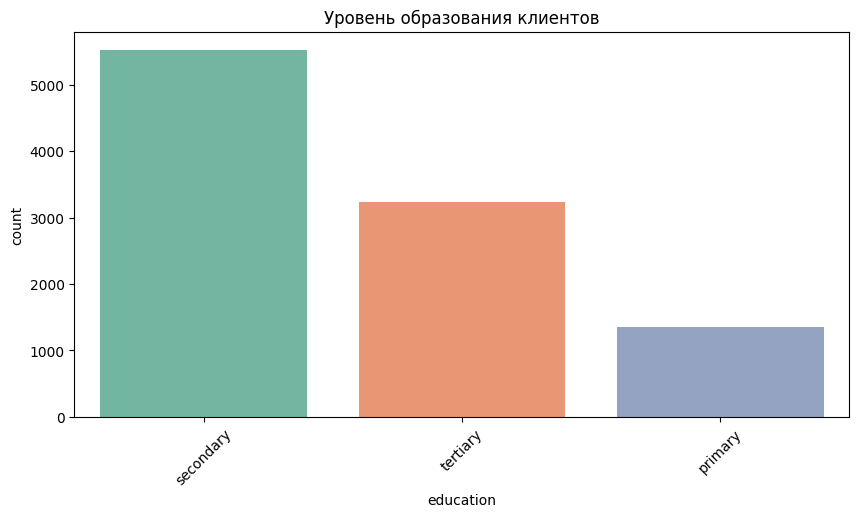

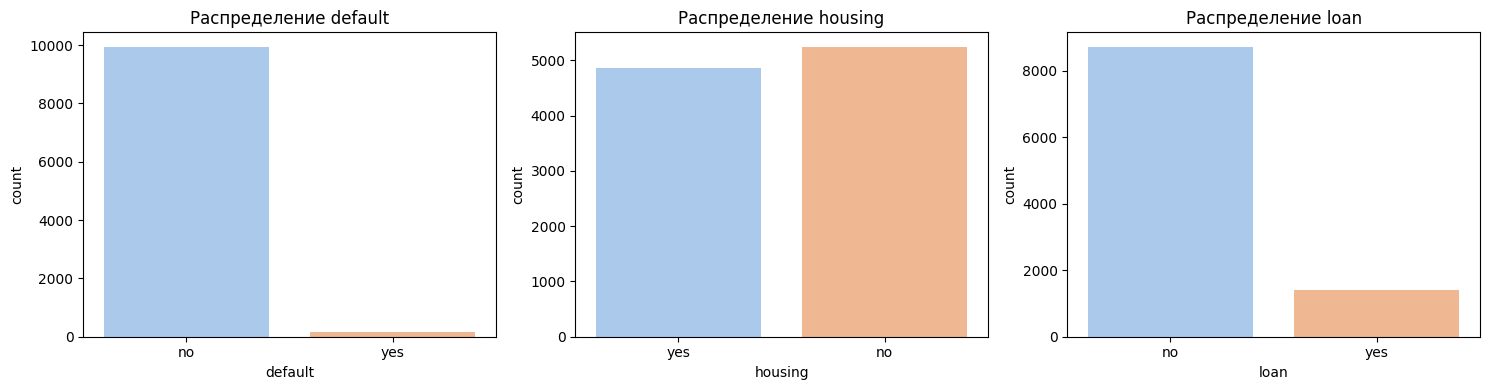

Уникальные месяцы: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
Маркетинговая кампания проводилась в 12 месяцах.


In [33]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

print("Уникальные категории job:", df['job'].nunique())
print(df['job'].value_counts(normalize=True).round(2))

plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='job', order=df['job'].value_counts().index, palette='viridis')
plt.title('Распределение клиентов по сфере занятости')
plt.show()

print("Распределение marital:\n", df['marital'].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
df['marital'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#99ff99','#ff9999'])
plt.title('Семейное положение клиентов')
plt.ylabel('')
plt.show()

print("Уровни образования:\n", df['education'].value_counts(normalize=True).round(2))

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='education', order=df['education'].value_counts().index, palette='Set2')
plt.title('Уровень образования клиентов')
plt.xticks(rotation=45)
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(['default', 'housing', 'loan']):
    sns.countplot(data=df, x=col, ax=axes[i], palette='pastel')
    axes[i].set_title(f'Распределение {col}')
plt.tight_layout()
plt.show()

unique_months = df['month'].unique()
print("Уникальные месяцы:", unique_months)

active_months_count = df['month'].nunique()
print(f"Маркетинговая кампания проводилась в {active_months_count} месяцах.")

### Задание 6

Распределение poutcome (%):
 poutcome
unknown    74.9
failure    11.0
success     9.4
other       4.8
Name: proportion, dtype: float64


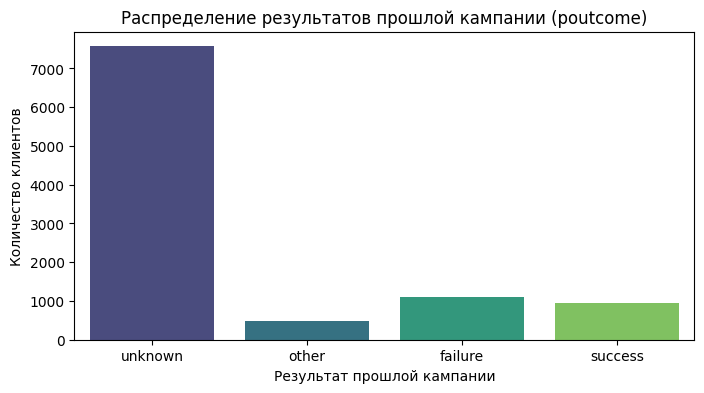

Доля согласий на депозит (%):
 poutcome
success    91.1
other      55.1
failure    49.3
unknown    39.7
Name: yes, dtype: float64
******************************
deposit     no   yes
poutcome            
failure    562   547
other      216   265
success     84   861
unknown   4562  3008


In [34]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

# Распределение статусов прошлой кампании
poutcome_distribution = df['poutcome'].value_counts(normalize=True) * 100
print("Распределение poutcome (%):\n", poutcome_distribution.round(1))

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='poutcome', palette='viridis')
plt.title('Распределение результатов прошлой кампании (poutcome)')
plt.xlabel('Результат прошлой кампании')
plt.ylabel('Количество клиентов')
plt.show()

# Группировка по poutcome и расчёт доли успешных депозитов
conversion_by_poutcome = df.groupby('poutcome')['deposit'].value_counts(normalize=True).unstack() * 100
conversion_by_poutcome = conversion_by_poutcome.sort_values(by='yes', ascending=False)
print("Доля согласий на депозит (%):\n", conversion_by_poutcome['yes'].round(1))

print('******************************')

# Группировка по poutcome и подсчёт количества ответов deposit
result = df.groupby('poutcome')['deposit'].value_counts().unstack()
print(result)

### Задание 7

In [35]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

# Считаем количество 'no' по месяцам
no_counts = df[df['deposit'] == 'no'].groupby('month').size().reset_index(name='no_count')
# Считаем количество 'yes' по месяцам
total_counts = df.groupby('month').size().reset_index(name='total_count')
# Объединяем два датафрейма по колонке 'month'
month_combined = pd.merge(no_counts, total_counts, on='month', how='outer')
# Посчитаем столбец где самый большой процент неудач
month_combined['no_ratio'] = round((month_combined['no_count'] / month_combined['total_count']) * 100, 2)

month_combined.sort_values(by='no_ratio', ascending=False)

,month,no_count,total_count,no_ratio
8,may,1776,2617,67.86
4,jan,194,319,60.82
5,jul,836,1418,58.96
9,nov,456,780,58.46
1,aug,775,1385,55.96
6,jun,606,1104,54.89
3,feb,323,709,45.56
0,apr,317,830,38.19
10,oct,62,335,18.51
11,sep,46,278,16.55


### Задание 8

In [ ]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

### Задания 9 и 10

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

### Задание 11

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# преобразуйте уровни образования

### Задания 2 и 3

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [ ]:
# создайте дамми-переменные

### Задания 5 и 6

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [ ]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели

### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna